In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sqlalchemy import create_engine, inspect

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

In [13]:
# the date 2 year ago from today
today = dt.date.today()
two_years_ago = dt.date.today() - dt.timedelta(days=2*365)

prcp=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= two_years_ago).order_by(Measurement.date).all()

df = pd.DataFrame(prcp, columns=['date', 'precipitation'])
df=df.dropna()
df= df.set_index('date')

#df.head()
#print(today)
#print(prcp_data)
#print(two_years_ago)

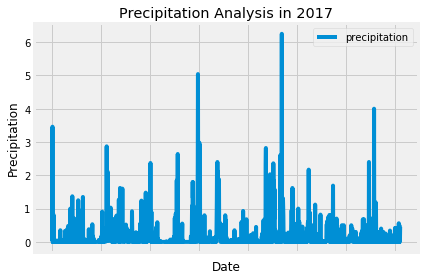

In [14]:
df.plot()
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Analysis in 2017')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("precipitation_analysis.png")
plt.show()

In [15]:
# the summary statistics for the precipitation data
df.describe()

,precipitation
count,1777.000000
mean,0.160501
std,0.426060
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


## Station Analysis

In [17]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1066a6f60>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [18]:
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1066b6908>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [19]:
# How many stations are available in this dataset?
total_stations= session.query(Station.station).count()
print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [20]:
# List the stations and the counts in descending order.
stations_count= session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# What are the most active stations?
print(f'The most active station is {stations_count[0][0]} with {stations_count[0][1]} obsertvations')

The most active station is USC00519281 with 2772 obsertvations


In [22]:
# the lowest temperature recorded, highest temperature recorded, and average temperature most active station
tobs_most_active_st = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == stations_count[0][0]).all()
print(tobs_most_active_st)

[(54.0, 85.0, 71.66378066378067)]


In [23]:
tobs_data=session.query(Measurement.tobs).\
    filter(Measurement.date > two_years_ago).\
    filter(Measurement.station == stations_count[0][0]).all()
#print(tobs_data)

In [24]:
tobs_df = pd.DataFrame(tobs_data)
#tobs_df.head()

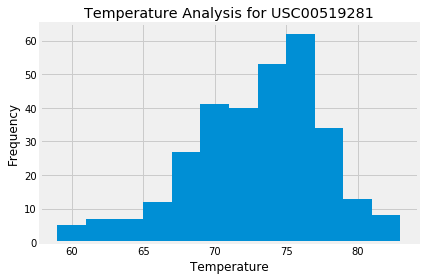

In [25]:
#a histogram with bins=12
plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Analysis for {stations_count[0][0]}')
plt.tight_layout()
plt.savefig("temperature_analysis.png")
plt.show()

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
start_date = dt.date(2012, 2, 28) 
end_date = dt.date(2012, 3, 5)
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
#the tmin, tavg, and tmax for the trip
new_start_date = dt.date(2017, 8, 2) 
new_end_date = dt.date(2017, 8, 9)
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= new_start_date).filter(Measurement.date <= new_end_date).all()
    
print(calc_temps ('2017-08-02', '2017-08-09'))

    

[(71.0, 79.58064516129032, 83.0)]


In [28]:
temp_df = pd.DataFrame(calc_temps ('2017-08-02', '2017-08-09'), columns=['min', 'avg', 'max'])
temp_df

,min,avg,max
0,71.0,79.580645,83.0


([], <a list of 0 Text xticklabel objects>)

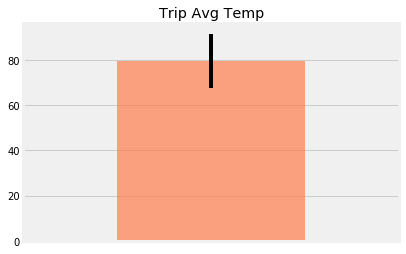

In [29]:
temp_df['avg'].plot(kind='bar', color='coral', alpha=0.7, yerr=temp_df['max'] - temp_df['min'])
plt.title("Trip Avg Temp")
plt.savefig("trip_avg_temp.png")
plt.xticks([])

In [30]:
data = [Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
prcp_data = session.query(*data).filter(Measurement.station==Station.station).\
    filter(Measurement.date >= new_start_date).\
    filter(Measurement.date <= new_end_date).\
    group_by(Station.station).\
    order_by(Measurement.prcp).all() 
print(prcp_data)
            

[(0.0, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (0.0, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (0.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (0.15, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
start=dt.date(2017, 8, 2)
end=dt.date(2017, 8, 9)

results = session.query(Measurement.date).\
    filter(Measurement.date >= start).\
    filter(Measurement.date <= end).\
    order_by(Measurement.date).all()
#print(dates)

result=[]
for x in results:
    result.append(x[0])
#print(result)
def remove_duplicates(result):
    return list(set(result))
without_duplicates = remove_duplicates(result)
without_duplicates.sort()
print(without_duplicates)

['2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09']


In [33]:
new_result=[]
for i in without_duplicates:
    new_result.append(i.split('2017-')[1])
print(new_result)

['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09']


In [34]:
normals =[]
for date in new_result:
    def daily_normals(date):
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
      
    normals.append(daily_normals(date)[0])  
normals


[(68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0)]

In [35]:
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
without_duplicates_df = pd.DataFrame(without_duplicates, columns=['date'])

In [36]:
trip_data_df = pd.concat([without_duplicates_df, normals_df], axis=1)
trip_data_df.set_index('date')

,tmin,tavg,tmax
date,,,
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0


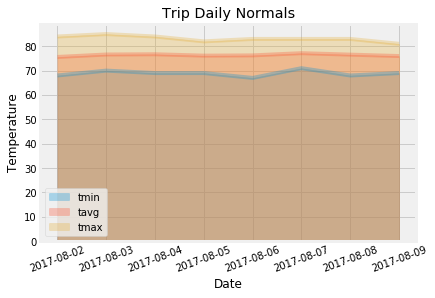

In [37]:
trip_data_df.plot.area(stacked=False, alpha=0.3)
plt.xticks(np.arange(8), ('2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07',\
                          '2017-08-08', '2017-08-09'), rotation=20)
plt.title("Trip Daily Normals")
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.savefig("trip-daily_normals.png")
plt.show()